In [6]:
%%bash
rm *.csv*
wget -nv https://storage.googleapis.com/cse144/{train,test}.csv

rm: *.csv*: No such file or directory
2022-02-12 17:44:00 URL:https://storage.googleapis.com/cse144/train.csv [32902/32902] -> "train.csv" [1]
2022-02-12 17:44:00 URL:https://storage.googleapis.com/cse144/test.csv [8270/8270] -> "test.csv" [1]
FINISHED --2022-02-12 17:44:00--
Total wall clock time: 0.1s
Downloaded: 2 files, 40K in 0.02s (2.20 MB/s)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format="retina"
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def plot_data(x: np.ndarray, y: np.ndarray) -> None: 
    """ Plot a dataset with 2-d feature vectors and binary labels.  Args:
        x: 2-d feature vectors
        y: 1-d binary labels.
    """
    class0_idx = np.where(y == 0)[0]
    class1_idx = np.where(y == 1)[0]
    feature0 = x[:, 0]
    feature1 = x[:, 1]
    plt.scatter(feature0[class0_idx], feature1[class0_idx], label="0")
    plt.scatter(feature0[class1_idx], feature1[class1_idx], label="1")
    plt.legend()
    plt.show()


def plot_decision_boundary(theta, x) -> None:
    """
    Plot the decision boundary using theta. Use this function with plot_data().

    Args:
        theta: a 3-d weight vector.
        x: 2-d feature vectors, which is used to decide the span of the decision
           boundary.
    """
    xx = np.linspace(min(x[:, 0]), max(x[:, 0]))
    yy = (-theta[1] / theta[2]) * xx - (theta[0]) / theta[2]
    plt.plot(xx, yy, color="red", label="boundary")
    plt.ylim(min(x[:, 1]), max(x[:, 1]))


# Read datasts and split training data into train & validation sets. Split
# features from labels after that.
test_dataset = pd.read_csv(
    "test.csv",
    names=["feature1", "feature2", "label"],
    na_values="?",
    comment="\t",
    sep=",",
    skipinitialspace=True,
).dropna().to_numpy()
test_dataset = test_dataset[1:,:]
train_dataset= pd.read_csv(
    "train.csv",
    names= ["feature1", "feature2", "label"],
    na_values="?",
    comment= "\t",
    sep = ",",
    skipinitialspace=True
).dropna().to_numpy()
train_dataset = train_dataset[1:,:] #drops first row
#print(train_dataset)
train_split,val_split = train_test_split(train_dataset, test_size = 0.2, random_state = 144, shuffle=True)
x_test =test_dataset[:, :-1]
y_test =test_dataset[:, -1]
x_test = x_test.astype(float)
y_test = y_test.astype(int)

x_train = train_split[:,:-1]
y_train = train_split[:,-1]

x_train=x_train.astype(float)
y_train=y_train.astype(int)

x_val = val_split[:, :-1]
y_val =val_split[:,-1]

x_val =x_val.astype(float)
y_val= y_val.astype(int)
#print(train_split, val_split)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)
#print(x_test)

(640, 2) (640,)
(160, 2) (160,)
(200, 2) (200,)


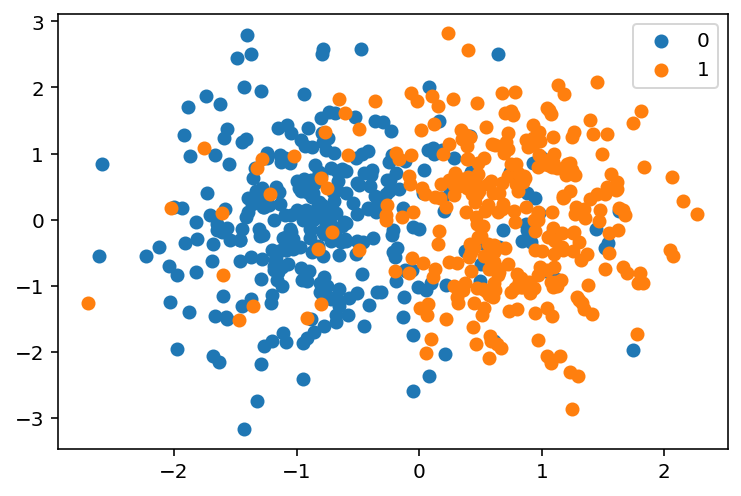

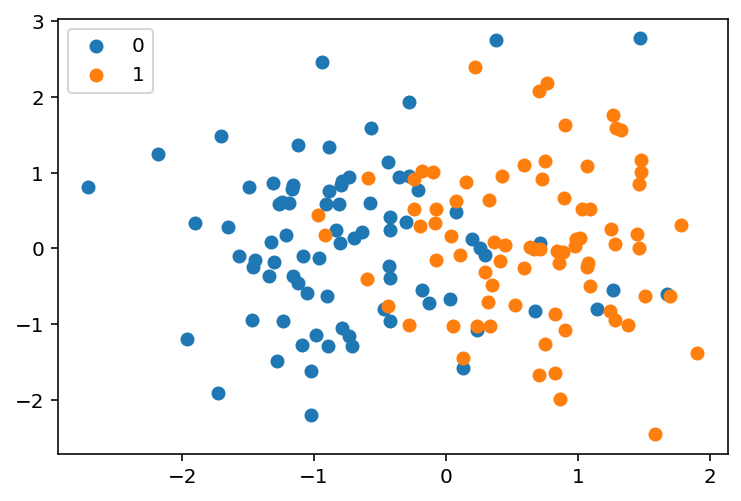

In [3]:
plot_data(x_train, y_train)
plot_data(x_val, y_val)

In [111]:
class LogisticRegressionTrainer:
    def __init__(
        self,
        num_features: int,
        learning_rate: float = 1e-2,
        num_epochs: int = 500,
        lambd: float = 0.0,
    ) -> None:
        """Initialize a logistic regression trainer."""
        self.lambd = lambd
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_features = num_features
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.test_loss = None
        self.test_acc = None

        self.theta = np.zeros(self.num_features + 1)

    def gradient_descent_step(self, x: np.ndarray, y: np.ndarray) -> None:
        """
        Perform a single step of gradient update.

        Args:
            x: A matrix of features.
            y: A vector of labels.
        """
        self.theta = self.theta - (self.learning_rate/y.shape[0]) * (self.cross_entropy_loss_derivative(x,y))

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """
        Convert raw model output (logits) to probabilities.

        Args:
            z: Raw model output (logits).

        Returns:
            A vector (or float, if your input is a scalar) of probabilties.
        """
        return 1.0/(1.0 + np.exp(-z))

    def cross_entropy_loss(self, pred: np.ndarray, target: np.ndarray) -> float:
        """
        Calculates the binary cross-entropy loss given predictions and targets.
        The loss function should add the regularization term.

        Args:
            pred: Predicted labels (probabilities).
            target: Ground-truth labels.

        Returns:
            A scalar of loss.
        """
        assert pred.shape == target.shape
        return (-1/pred.shape[0]) * np.sum(target * np.log(pred) + (1 - target) * np.log(pred)) + self.lambd * np.sum(self.theta[1:] ** 2)

    def cross_entropy_loss_derivative(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculates the derivative of the loss function w.r.t. theta. The derivative of the
        loss function should also add the derivative of the L2 regularization term.

        Args:
            x: Feature vectors.
            y: Ground-truth labels.

        Returns:
            A vector with the same dimension as theta, where each element is the
            partial derivative of the loss function w.r.t. the corresponding element
            in theta.
        """
        return x.T.dot((self.sigmoid(x @ self.theta) - y)) + self.lambd * np.sum(self.theta[1:] * 2) 

    def accuracy(self, pred: np.ndarray, target: np.ndarray) -> float:
        """
        Calculates the percentage of matched labels given predictions and targets.

        Args:
            pred: Predicted labels (rounded probabilities).
            target: Ground-truth labels.

        Return:
            The accuracy score (a float) given the predicted labels and the true labels.
        """
        assert pred.shape == target.shape
        p_count = 0
        for i in range(pred.shape[0]):
            if pred[i] > 0 and target[i] == 1: # correct guess
                p_count = p_count + 1
            elif pred[i] < 0 and target[i] == 0:
                p_count = p_count + 1
        return (p_count / pred.shape[0]) * 100

    def train(
        self,
        x_train: np.ndarray,
        y_train: np.ndarray,
        x_val: np.ndarray,
        y_val: np.ndarray,
    ) -> None:
        """
        Run gradient descent for n epochs, where n = self.num_epochs. 
        Args:
            x_train: Feature vectors for training.
            y_train: Ground-truth labels for training.
            x_val: Feature vectors for validation.
            y_val: Ground-truth labels for validation.
        """
        x_train = np.concatenate((np.ones((x_train.shape[0], 1)), x_train), axis = 1)
        x_val = np.concatenate((np.ones((x_val.shape[0], 1)),x_val), axis = 1)
        for i in range(self.num_epochs):
            self.train_loss_history.append(self.cross_entropy_loss(self.sigmoid(x_train @ self.theta.T), y_train))
            self.train_acc_history.append(self.accuracy(x_train @ self.theta.T, y_train))
            self.val_loss_history.append(self.cross_entropy_loss(self.sigmoid(x_val @ self.theta.T) ,y_val))
            self.val_acc_history.append(self.accuracy(x_val @ self.theta.T, y_val))
            self.gradient_descent_step(x_train, y_train)
        

    def evaluate(self, x_test: np.ndarray, y_test: np.ndarray) -> None:
        """
        Evaluate the model on test set and store the test loss int self.test_loss and 
        test accuracy in self.test_acc.

        If you used the bias trick in train(), you have to also use it here.

        Args:
            x_test: Feature vectors for testing.
            y_test: Ground-truth labels for testing.
        """
        x_test = np.concatenate((np.ones((x_test.shape[0], 1)), x_test), axis = 1)
        self.test_loss = self.cross_entropy_loss(self.sigmoid(x_test @ self.theta.T), y_test)
        self.test_acc = self.accuracy(x_test @ self.theta.T, y_test)

Final train loss: 1.1399384206526204
Final validation loss: 1.1396152899917706


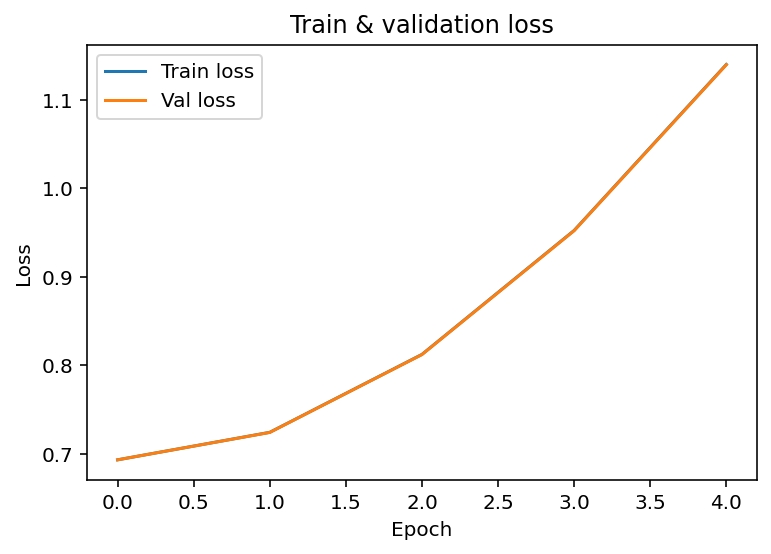

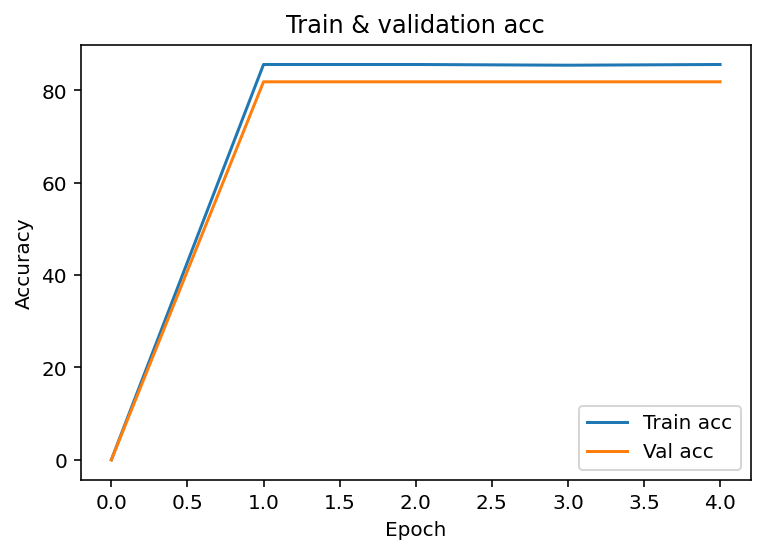

In [167]:
alpha = 0.05
iterations = 5
l = 100
trainer = LogisticRegressionTrainer(num_features = 2, learning_rate = alpha, num_epochs = iterations, lambd = l)
trainer.train(x_train,y_train, x_val,y_val)

print(f"Final train loss: {trainer.train_loss_history[-1]}")
print(f"Final validation loss: {trainer.val_loss_history[-1]}")

plt.plot(np.arange(trainer.num_epochs), trainer.train_loss_history, label="Train loss")
plt.plot(np.arange(trainer.num_epochs), trainer.val_loss_history, label="Val loss")
plt.title("Train & validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(np.arange(trainer.num_epochs), trainer.train_acc_history, label="Train acc")
plt.plot(np.arange(trainer.num_epochs), trainer.val_acc_history, label="Val acc")
plt.title("Train & validation acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

My logistic regression weights: [-0.00635799  0.08193686  0.00058233]


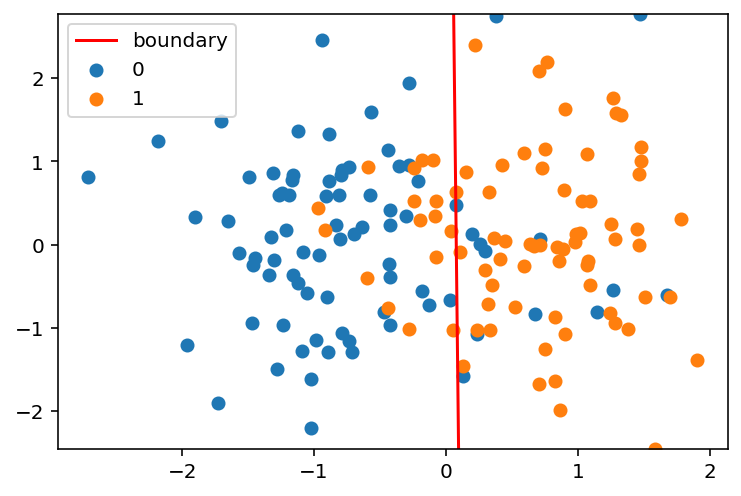

Sklearn logisitic regression weights: [-0.03111199  2.13964495  0.09423809]


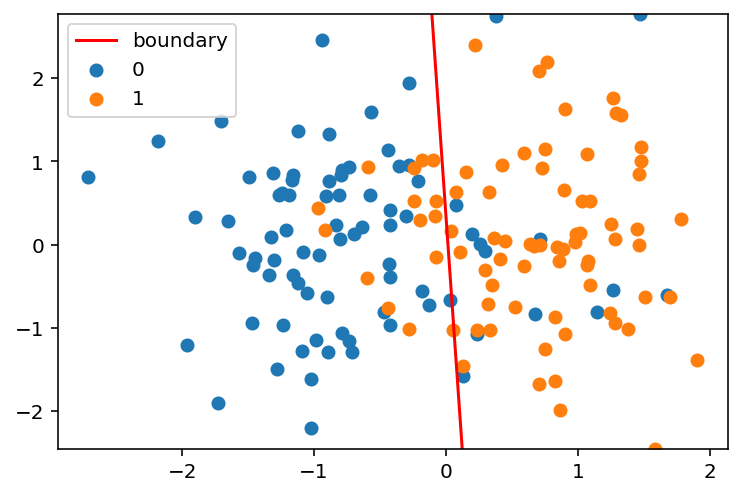

In [168]:
# 0 = theta0 + theta1 * x + theta2 * y
# y = (-theta0 - theta1 * x) / theta2
print(f"My logistic regression weights: {trainer.theta}")
plot_decision_boundary(trainer.theta, x_val)
plot_data(x_val, y_val)

model = LogisticRegression(penalty="l2", n_jobs=-1).fit(x_train, y_train)
print(f"Sklearn logisitic regression weights: {np.append(model.intercept_, model.coef_)}")
plot_decision_boundary(np.append(model.intercept_, model.coef_), x_val)
plot_data(x_val, y_val)

# Evaluation

In [169]:
trainer.evaluate(x_test, y_test)
print(f"Test loss: {trainer.test_loss}")
print(f"Test acc: {trainer.test_acc}")

Test loss: 1.369898926943691
Test acc: 89.0
